# Visualize QA

In [1]:
import os
from math import exp, cos, pi, sqrt, isclose
from cmath import exp as cplx_exp
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc

%matplotlib inline

## Define QA updater

In [2]:
def generate_diag_time_evolving_op_with_H0(cost_function_values, delta_t, s, M):
    """ Generate diagonal elements oftime evolving operator with H0 term
    
    Parameters
    ----------
    cost_function_values : 1-d array
        Values of cost function for each option.
    delta_t : float
        Time step of QA.
    s : float
        Control parameter of QA at current time. The total Hamiltonian is H(t) = s(t) H0 + (1-s(t)) V.
    M : int
        The number of Trotter slices.
        
    Returns
    -------
    Diagonal elements of infinitesimal time evoluting operator with regards to H0.
    """
    return np.exp(-1.0j*(delta_t*s/M)*cost_function_values)

def generate_time_evolving_op_with_V(delta_t, s, M, size):
    """ Generate time evolving operator with V term
    
    Parameters
    ----------
    delta_t : float
        Time step of QA.
    s : float
        Control parameter of QA at current time. The total Hamiltonian is H(t) = s(t) H0 + (1-s(t)) V.
    M : int
        The number of Trotter slices.
    size: int
        The size of matrix (time evolving op is a size x size matrix).
    
    Returns
    -------
    Infinitesimal time evoluting operator with regards to V.
    """
    return cplx_exp(-1.0j*delta_t*(1.0-s)/M) * (np.identity(size)
                                                + ((cplx_exp(1.0j*delta_t*size*(1-s)/M)-1.0)/size) * np.ones((size,size)))

def proceed_infinitesimal_time(state, cost_function_values, delta_t, s, M):
    """ Proceed quantum state with infinitesimal time evolving operator.

    Parameters
    ----------
    state: 1-d array
        Quantum state vector.
    cost_function_values : 1-d array
        Values of cost function for each option.
        The shape must be the same as that of `state`.
    delta_t : float
        Time step of QA.
    s : float
        Control parameter of QA at current time. The total Hamiltonian is H(t) = s(t) H0 + (1-s(t)) V.
    M : int
        The number of Trotter slices.
        
    Returns
    -------
    Updated quantum state
    """
    size = cost_function_values.shape[0]
    diag_U_H0 = generate_diag_time_evolving_op_with_H0(cost_function_values, delta_t, s, M)
    U_V = generate_time_evolving_op_with_V(delta_t, s, M, size)
    ret_state = state
    for _ in range(M):
        ret_state = diag_U_H0 * (U_V @ ret_state)
    return ret_state

## Unit test for the time evolving function

Simulate the Larmor precession

### External field along with z direction

In [3]:
# Initial state pointing at +x direction
state = np.array([1.0+0.0j, 1.0+0.0j])/sqrt(2.0)
cost_function_values = np.array([1.0, -1.0])
delta_t = 0.01
s = 1.0
M = 100

data_dir = '../data/larmor'
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
fname = os.path.join(data_dir, 'data_along_z.dat')

data = []
sigmax = np.array([[0.0, 1.0], [1.0, 0.0]])
for t in np.arange(0.0, 2.0*pi, delta_t)[1:]:
    state = proceed_infinitesimal_time(state, cost_function_values, delta_t, s, M)
    data.append([t, (np.conj(state)@sigmax@state).real])

np.savetxt(fname, data)

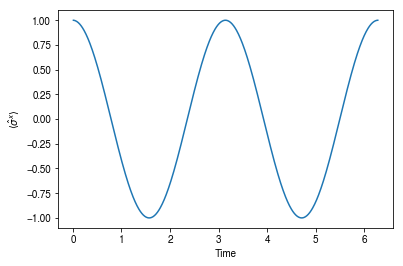

In [4]:
# Plot result
data = np.loadtxt(fname)
X = data[:, 0]
Y = data[:, 1]
plt.xlabel('Time')
plt.ylabel(r'$\langle \hat{\sigma}^{x} \rangle$')
plt.plot(X,Y);

### External field along with x direction

In [5]:
# Initial state pointing at -z direction
state = np.array([0.0+0.0j, 1.0+0.0j])
cost_function_values = np.array([1.0, -1.0])
delta_t = 0.01
s = 0.0
M = 100

data_dir = '../data/larmor'
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
fname = os.path.join(data_dir, 'data_along_x.dat')

data = []
sigmaz = np.array([[1.0, 0.0], [0.0, -1.0]])
for t in np.arange(0.0, 2.0*pi, delta_t)[1:]:
    state = proceed_infinitesimal_time(state, cost_function_values, delta_t, s, M)
    data.append([t, (np.conj(state)@sigmaz@state).real])

np.savetxt(fname, data)

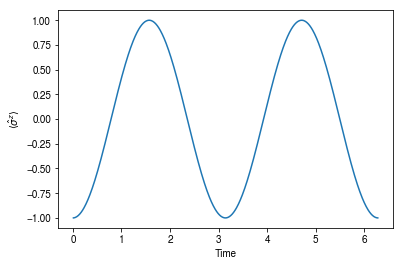

In [6]:
# Plot result
data = np.loadtxt(fname)
X = data[:, 0]
Y = data[:, 1]
plt.xlabel('Time')
plt.ylabel(r'$\langle \hat{\sigma}^{z} \rangle$')
plt.plot(X,Y);

## Function 1

In [7]:
# Define objective function
def f(x):
    square = x * x
    return square * (square - 0.98) - 0.08 * x + 0.1 * cos(10.0 * pi * x)

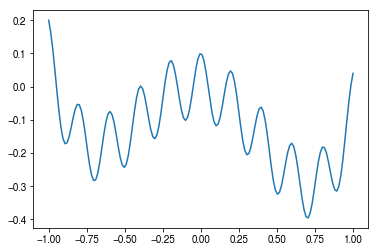

In [8]:
xp = np.linspace(-1.0, 1.0, num=150)
yp = [f(x) for x in xp]
plt.plot(xp, yp);

Define functions to save and load data with complex values

In [9]:
def save_data(fname, t, state):
    size = state.shape[0]
    fmt = ['%.4f'] + ['%.16e', '%.16e']*size
    aranged_data = np.stack((state.real, state.imag), axis=1).ravel()
    aranged_data = np.insert(aranged_data, 0, t)
    np.savetxt(fname, aranged_data[None, :], fmt=fmt)

def load_data(fname):
    X = np.loadtxt(fname)
    t = X[:, 0]
    real_part = X[:, 1::2]
    imag_part = X[:, 2::2]
    state = real_part + 1.0j * imag_part
    return t, state

Generate data

In [10]:
size = 150
delta_t = 0.01
interval = round(10/delta_t)
tau = 1000
M = 100

data_dir = '../data/function1'
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)
    
fname = os.path.join(data_dir, 'QA_tau{0:.4f}_deltaT{1:.4f}_M{2:d}.dat'.format(tau, delta_t, M))

cost_function_values = np.array([f(x) for x in np.linspace(-1.0, 1.0, num=size)])
diag_norm = np.linalg.norm(cost_function_values)
normalized_H0_diag = (4 * size/diag_norm) * cost_function_values
state = np.ones(size, dtype=np.complex128)/sqrt(size)

def get_s(t):
    return t/tau

counter = 0
t = 0.0
with open(fname, 'bw') as fout:
    save_data(fout, t, state)
    while True:
        t += delta_t
        if t > tau:
            # Save the last state
            if counter != 0:
                save_data(fout, t-delta_t, state)
                print('t={:.4f} finished'.format(t-delta_t), flush=True)
            break
        counter += 1
        s = get_s(t)
        state = proceed_infinitesimal_time(state, normalized_H0_diag, delta_t, s, M)
        if counter%interval == 0:
            counter = 0
            save_data(fout, t, state)
            print('t={:.4f} finished'.format(t), flush=True)

t=10.0000 finished
t=20.0000 finished
t=30.0000 finished
t=40.0000 finished
t=50.0000 finished
t=60.0000 finished
t=70.0000 finished
t=80.0000 finished
t=90.0000 finished
t=100.0000 finished
t=110.0000 finished
t=120.0000 finished
t=130.0000 finished
t=140.0000 finished
t=150.0000 finished
t=160.0000 finished
t=170.0000 finished
t=180.0000 finished
t=190.0000 finished
t=200.0000 finished
t=210.0000 finished
t=220.0000 finished
t=230.0000 finished
t=240.0000 finished
t=250.0000 finished
t=260.0000 finished
t=270.0000 finished
t=280.0000 finished
t=290.0000 finished
t=300.0000 finished
t=310.0000 finished
t=320.0000 finished
t=330.0000 finished
t=340.0000 finished
t=350.0000 finished
t=360.0000 finished
t=370.0000 finished
t=380.0000 finished
t=390.0000 finished
t=400.0000 finished
t=410.0000 finished
t=420.0000 finished
t=430.0000 finished
t=440.0000 finished
t=450.0000 finished
t=460.0000 finished
t=470.0000 finished
t=480.0000 finished
t=490.0000 finished
t=500.0000 finished
t=510.000

Process data

In [11]:
size = 150
delta_t = 0.01
tau = 1000
M = 100
data_dir = '../data/function1'
fname = os.path.join(data_dir, 'QA_tau{0:.4f}_deltaT{1:.4f}_M{2:d}.dat'.format(tau, delta_t, M))
t, state = load_data(fname)

prob_amplitude = np.absolute(state)**2

Plot data

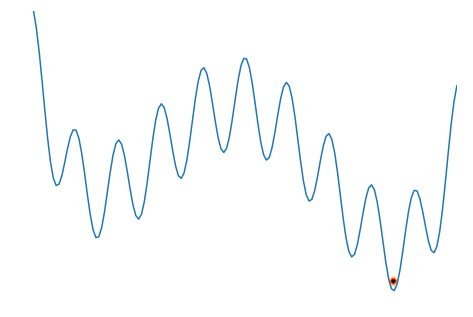

In [12]:
X = np.linspace(-1.0, 1.0, num=size)
xmin, xmax = X[0], X[-1]
ysize = 100
tsize = t.shape[0]

fig, ax = plt.subplots(figsize=(6,4))
fig.subplots_adjust(top=0.99, left=0.01, right=0.99, bottom=0.01)
ax.set_ylim(-0.4, 0.2)
ax.set_xlim(-1, 1)
ax.axis('off')
yp = np.array([f(x) for x in X])
ymin, ymax = np.amin(yp), np.amax(yp)
extent = xmin, xmax, ymin, ymax

def generate_image_data(size, ysize, probability_amplitude, cost_function_values,
                        ysize_margin, ymin, ymax):
    img_data = np.zeros((ysize, size))
    sigma_max, sigma_min = 1.5, 0.5
    Energy = probability_amplitude @ cost_function_values
    if Energy >= ymax:
        col_index = -1
        sigma = sigma_max
    elif Energy <= ymin:
        col_index = 0
        sigma = sigma_min
    else:
        percent = (Energy - ymin) / (ymax - ymin)
        col_index = int(round(percent*(ysize-2*ysize_margin) + ysize_margin))
        sigma = sigma_min + (sigma_max-sigma_min) * percent
    img_data[col_index, :] = probability_amplitude ** (2/3)
    img_data = gaussian_filter(img_data, sigma=sigma)
    return img_data

img_data = generate_image_data(size, ysize, prob_amplitude[0], yp,
                               ysize_margin=3, ymin=ymin, ymax=ymax-0.2)

line, = ax.plot(X, yp)
img = ax.imshow(img_data, cmap='gist_heat_r', vmin=0.0, vmax=0.35,
                aspect='auto', extent=extent, origin='lower',
                interpolation='gaussian', animated=True)

def update_fig(i):
    img_data = generate_image_data(size, ysize, prob_amplitude[i], yp,
                               ysize_margin=3, ymin=ymin, ymax=ymax-0.2)
    img.set_array(img_data)
    return img,

ani = animation.FuncAnimation(fig, update_fig, tsize, interval=100, blit=True)
ani.save('QA.mp4', dpi=100)